In [ ]:
from google.colab import files

# Kaggle JSON'u Yükleme
files.upload()

# Kaggle JSON'u Doğru Konuma Taşıma
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Kaggle Veri Setini İndirme
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 75% 61.0M/80.9M [00:00<00:00, 209MB/s]
100% 80.9M/80.9M [00:00<00:00, 224MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


Loading and preprocessing data...
olumlu ve olumsuz örnekler ayrılıyor
Cleaning text data...
Data loaded and preprocessed. Total rows: 1600
Building similarity graph...
Graph created with 800 nodes and 4859 edges.
Building similarity graph...
Graph created with 800 nodes and 4453 edges.
Visualizing Positive Graph graph...


<ipython-input-52-1bd353491f5d>:127: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(graph.nodes(), min(100, len(graph.nodes())))


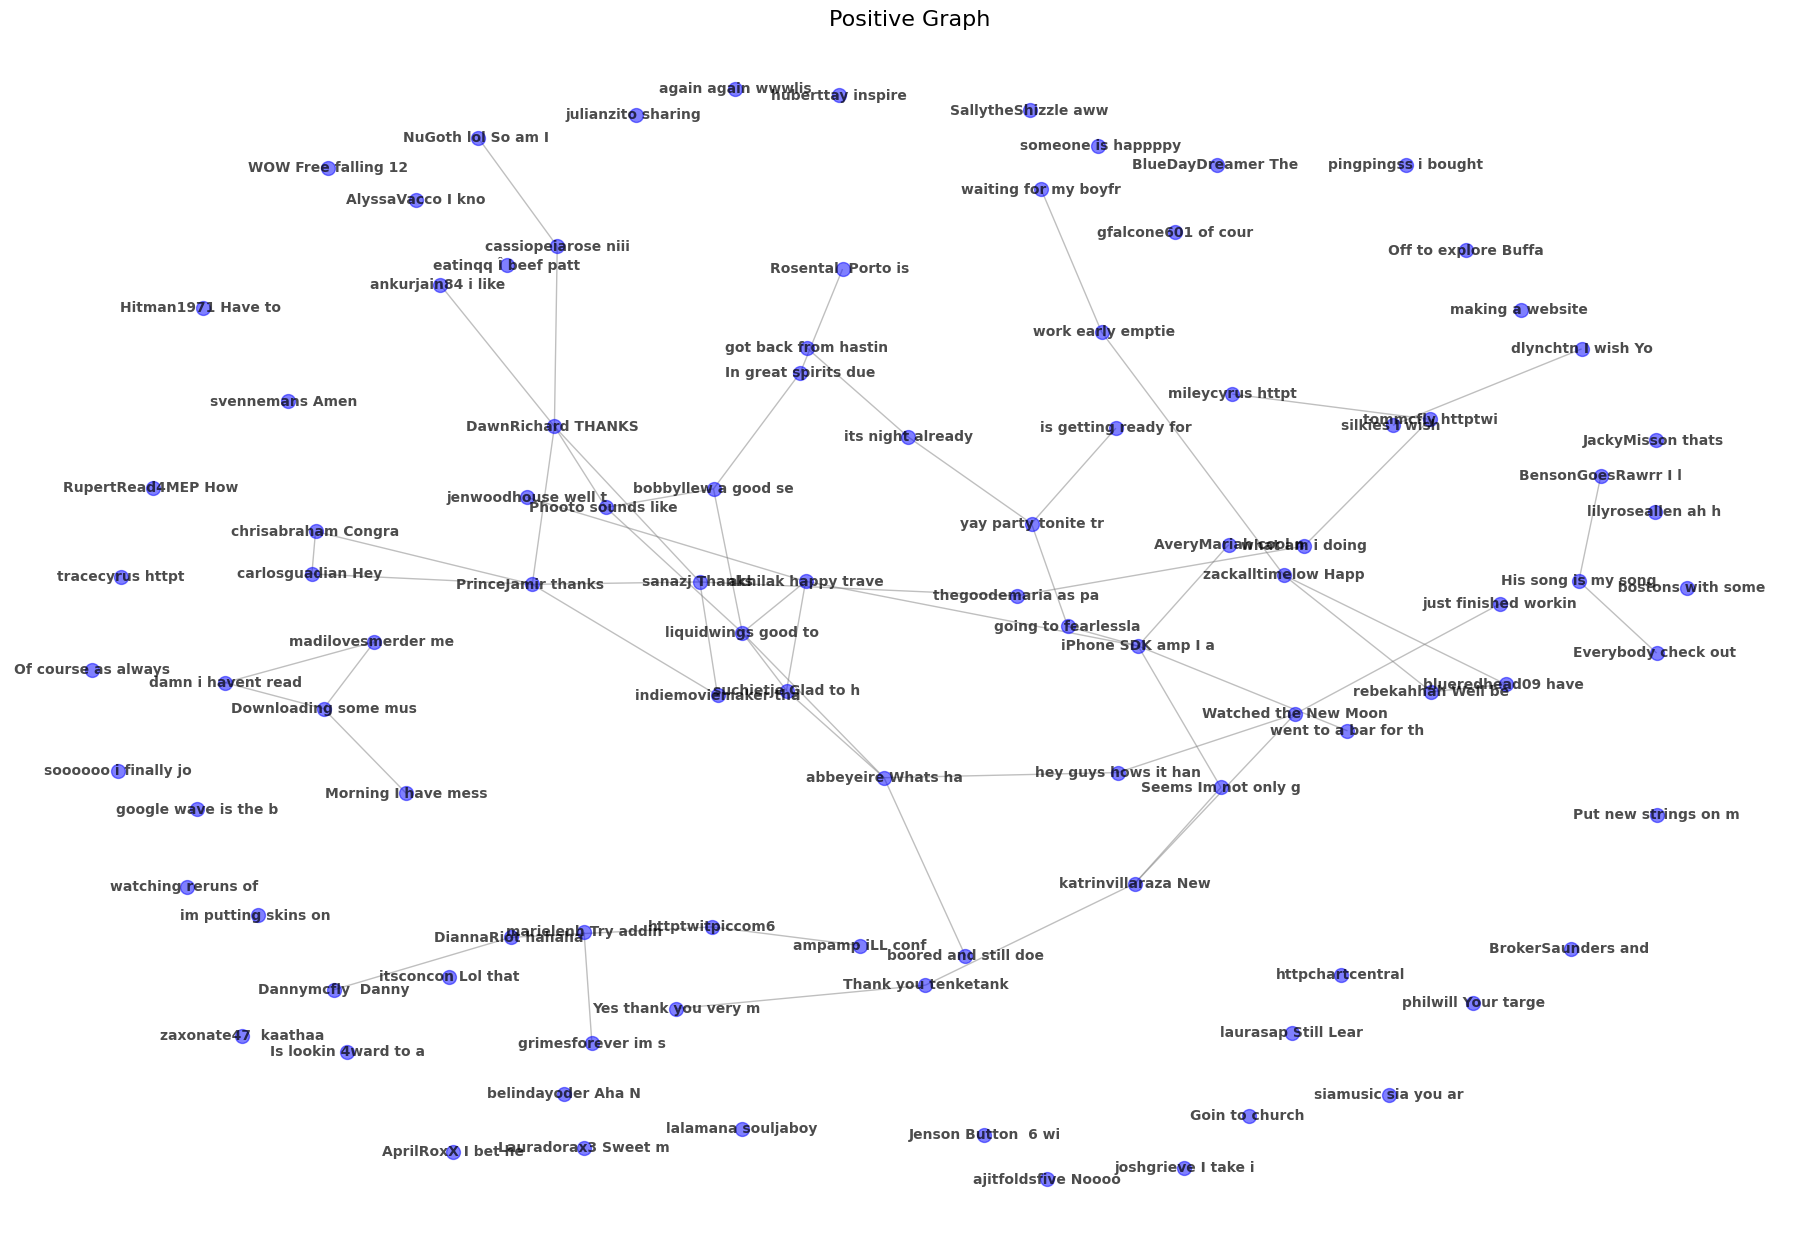

Visualizing Negative Graph graph...


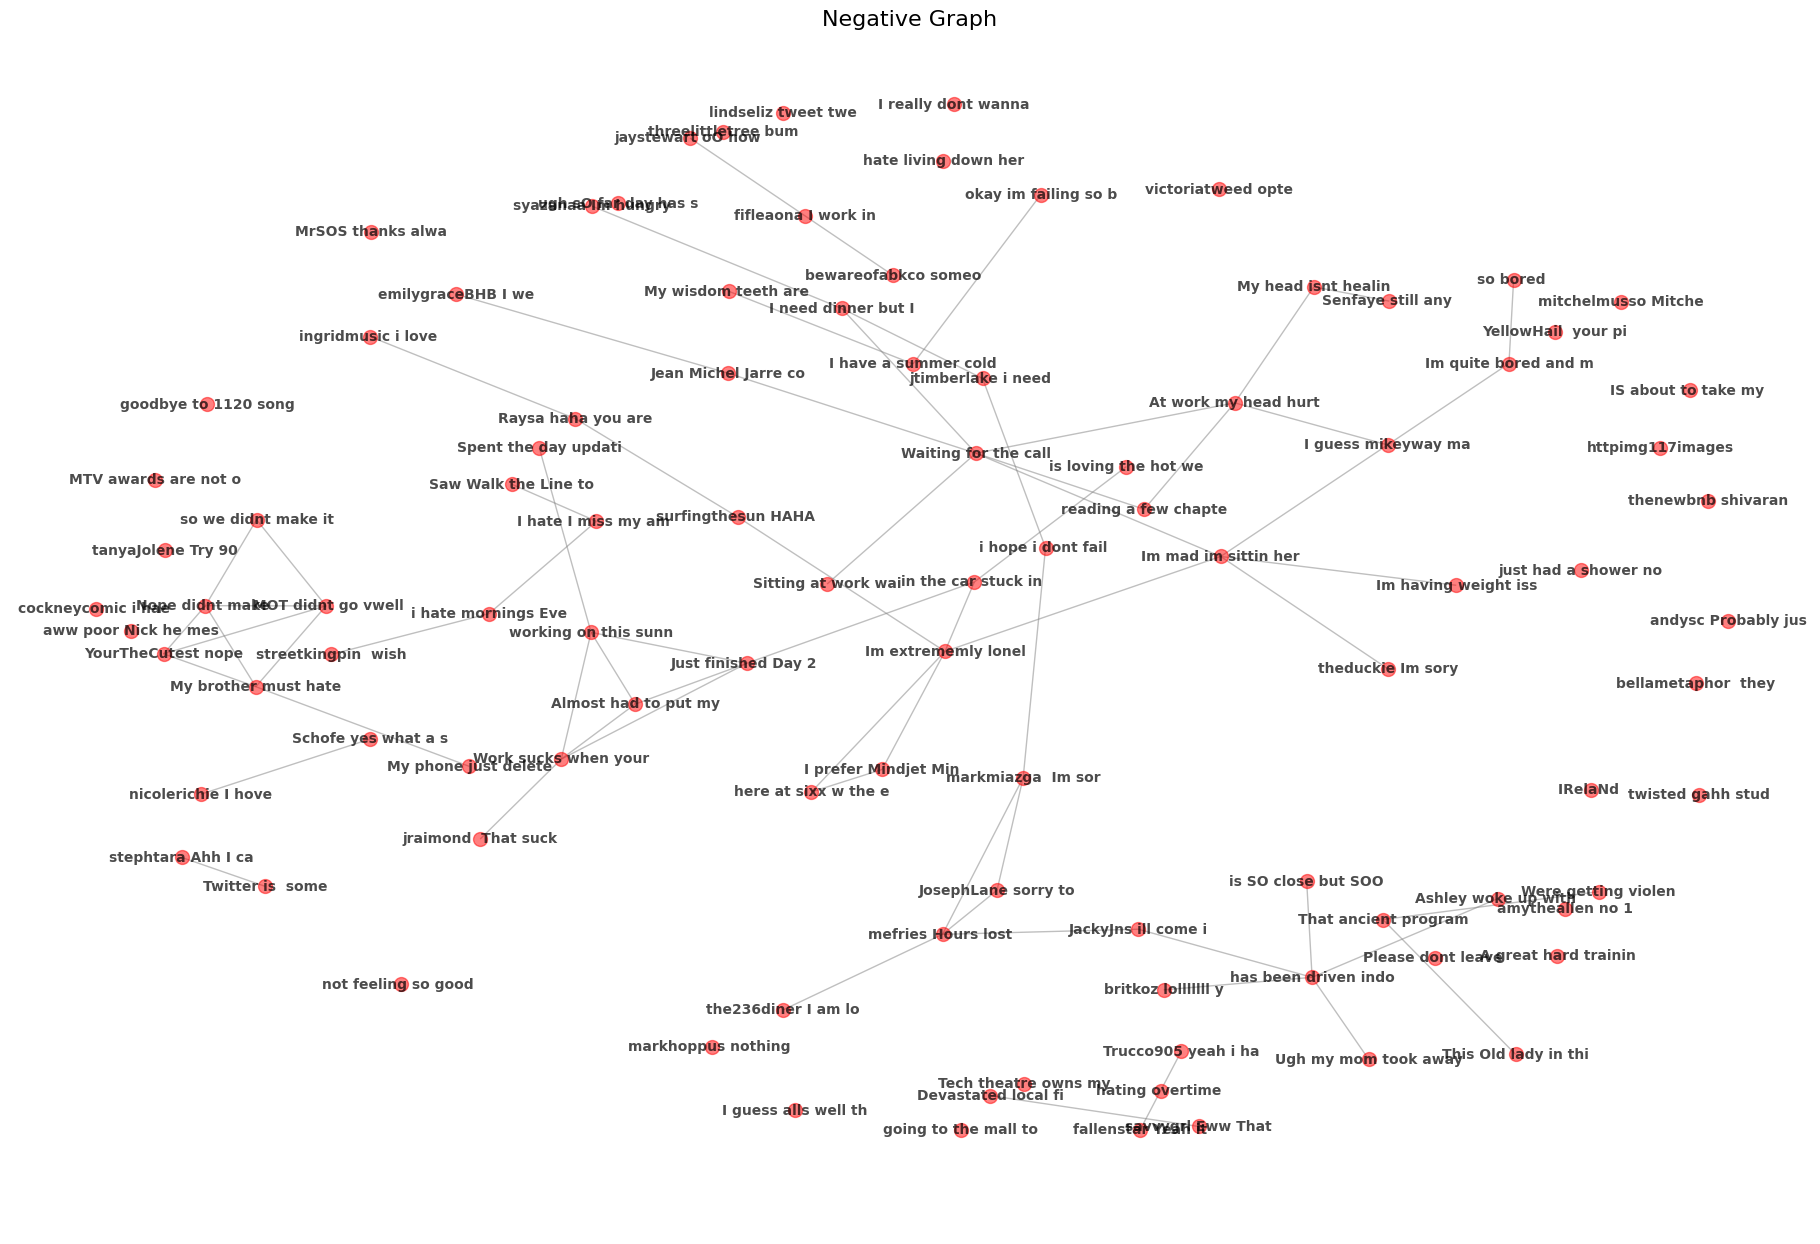

Enter your tweets below (type 'exit' to stop):
Enter a tweet: ı love it
Predicting sentiment for the tweet: ı love it
Positive Centrality: 291.0278618418616
Negative Centrality: 184.65929650834346
Predicted sentiment: Positive
The sentiment of the tweet is: Positive
Enter a tweet: ı hate it
Predicting sentiment for the tweet: ı hate it
Positive Centrality: 5.9051083278562215
Negative Centrality: 147.90465078732404
Predicted sentiment: Negative
The sentiment of the tweet is: Negative
Enter a tweet: ı dont know anything
Predicting sentiment for the tweet: ı dont know anything
Positive Centrality: 95.25699097037317
Negative Centrality: 193.21268657284762
Predicted sentiment: Negative
The sentiment of the tweet is: Negative
Enter a tweet: exit
Exiting...


In [ ]:
import pandas as pd
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# 1. Verilerin Yüklenmesi ve Ön İşlenmesi
def load_and_preprocess_data(file_path, frac=0.001):
    print("Loading and preprocessing data...")
    data = pd.read_csv(file_path, encoding='latin1', header=None)
    data.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

    data = data[['target', 'text']]
    data['sentiment'] = data['target'].apply(lambda x: 1 if x == 4 else 0)
    data = data[['text', 'sentiment']]

    print("olumlu ve olumsuz örnekler ayrılıyor")
    positive_tweets = data[data['sentiment'] == 1]
    negative_tweets = data[data['sentiment'] == 0]

    # Her sınıftan belirli bir oranda örnek al
    positive_sample = positive_tweets.sample(frac=frac, random_state=42)
    negative_sample = negative_tweets.sample(frac=frac, random_state=42)

    # Dengeli veri kümesini birleştir
    balanced_data = pd.concat([positive_sample, negative_sample]).sample(frac=1, random_state=42)

    print("Cleaning text data...")
    balanced_data['cleaned_text'] = balanced_data['text'].str.replace(r"http\S+|www.\S+", "", regex=True)
    balanced_data['cleaned_text'] = balanced_data['cleaned_text'].str.replace(r"[^a-zA-Z\s]", "", regex=True).str.lower()

    print(f"Data loaded and preprocessed. Total rows: {len(balanced_data)}")
    return balanced_data

# 2. Benzerlik Grafiği Oluşturma
def build_similarity_graph(data, vectorizer, threshold=0.2):
    print("Building similarity graph...")
    graph = nx.Graph()

    tfidf_matrix = vectorizer.transform(data['cleaned_text'])
    similarity_matrix = cosine_similarity(tfidf_matrix)

    for i in range(similarity_matrix.shape[0]):
        for j in range(i + 1, similarity_matrix.shape[0]):
            similarity = similarity_matrix[i, j]
            if similarity > threshold:
                graph.add_edge(i, j, weight=similarity)

    # Düğüm özelliklerini ayarla
    for i, (idx, row) in enumerate(data.iterrows()):
        graph.add_node(i, sentiment=row['sentiment'], text=row['text'])

    print(f"Graph created with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")
    return graph

# 3. Malatya Centrality Hesaplama
def calculate_malatya_centrality(graph):
    centrality = {}
    for node in graph.nodes:
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            centrality[node] = 0
        else:
            centrality[node] = sum(graph.degree[node] / graph.degree[n] for n in neighbors)
    return centrality

# 4. Yeni Tweet Tahmini
def predict_sentiment(new_tweet, positive_graph, negative_graph, vectorizer):
    print(f"Predicting sentiment for the tweet: {new_tweet}")
    new_tfidf = vectorizer.transform([new_tweet])

    # Pozitif graf için benzerlikler
    positive_similarity = cosine_similarity(new_tfidf, vectorizer.transform(
        [positive_graph.nodes[node]['text'] for node in positive_graph.nodes]))
    positive_centrality = sum(
        calculate_malatya_centrality(positive_graph).get(node, 0) * similarity
        for node, similarity in enumerate(positive_similarity[0])
    )

    # Negatif graf için benzerlikler
    negative_similarity = cosine_similarity(new_tfidf, vectorizer.transform(
        [negative_graph.nodes[node]['text'] for node in negative_graph.nodes]))
    negative_centrality = sum(
        calculate_malatya_centrality(negative_graph).get(node, 0) * similarity
        for node, similarity in enumerate(negative_similarity[0])
    )

    print(f"Positive Centrality: {positive_centrality}")
    print(f"Negative Centrality: {negative_centrality}")

    result = "Positive" if positive_centrality > negative_centrality else "Negative"
    print(f"Predicted sentiment: {result}")
    return result

def sanitize_label(label):
    return ''.join(e for e in label if e.isalnum() or e.isspace())


import random

def visualize_graph(graph, title, node_color):
    print(f"Visualizing {title} graph...")

    # Randomly sample 100 nodes (or fewer if there aren't enough nodes)
    sampled_nodes = random.sample(graph.nodes(), min(100, len(graph.nodes())))

    # Create a subgraph of the sampled nodes
    subgraph = graph.subgraph(sampled_nodes)

    # Use spring layout with more iterations to spread out the nodes
    pos = nx.spring_layout(subgraph, k=0.15, iterations=30)

    plt.figure(figsize=(18, 12))

    # Increase node size and use a more readable alpha
    nx.draw(subgraph, pos, with_labels=False, node_size=100, node_color=node_color, edge_color="gray", alpha=0.5)

    # Clean and set node labels
    labels = {node: sanitize_label(subgraph.nodes[node]['text'][:20] + '...') for node in subgraph.nodes}

    # Adjust label font size for better readability and avoid overlap
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=10, font_color="black", font_weight='bold', alpha=0.7)

    # Set the title for the plot
    plt.title(title, fontsize=16)
    plt.show()




# Ana Program
if __name__ == "__main__":
    # Verileri yükle ve örnekle
    data = load_and_preprocess_data("training.1600000.processed.noemoticon.csv", frac=0.001)

    # TF-IDF vektörleştirici oluştur
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(data['cleaned_text'])

    # Olumlu ve olumsuz tweetleri ayır
    positive_data = data[data['sentiment'] == 1]
    negative_data = data[data['sentiment'] == 0]

    # Olumlu ve olumsuz grafikleri oluştur
    positive_graph = build_similarity_graph(positive_data, vectorizer, threshold=0.2)
    negative_graph = build_similarity_graph(negative_data, vectorizer, threshold=0.2)

    # Malatya Centrality değerlerini hesapla
    positive_centrality = calculate_malatya_centrality(positive_graph)
    negative_centrality = calculate_malatya_centrality(negative_graph)

    nx.set_node_attributes(positive_graph, positive_centrality, 'malatya_centrality')
    nx.set_node_attributes(negative_graph, negative_centrality, 'malatya_centrality')

    # Grafikleri görselleştir
    visualize_graph(positive_graph, "Positive Graph", "blue")
    visualize_graph(negative_graph, "Negative Graph", "red")

    # Kullanıcıdan tweet girişini al ve tahmin yap
    print("Enter your tweets below (type 'exit' to stop):")
    while True:
        new_tweet = input("Enter a tweet: ")
        if new_tweet.lower() == 'exit':
            print("Exiting...")
            break
        sentiment = predict_sentiment(new_tweet, positive_graph, negative_graph, vectorizer)
        print(f"The sentiment of the tweet is: {sentiment}")
